In [29]:
import pandas as pd
import os 
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import sentencepiece
import seaborn as sns
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification
import random
from scipy.stats import pearsonr
import numpy as np
from transformers import TrainerCallback
import torch
from collections import Counter





In [2]:
# Add the dataset path and import
dataset_path = "Datasets/us-patent-phrase-to-phrase-matching/"
df = pd.read_csv(os.path.join(dataset_path, "train.csv"))

In [31]:
# Set seeds
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(777)

In [4]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


C:\Users\86188\AppData\Local\Temp\ipykernel_15444\1081371691.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(x='score', data=df, palette='hls', ax=ax)


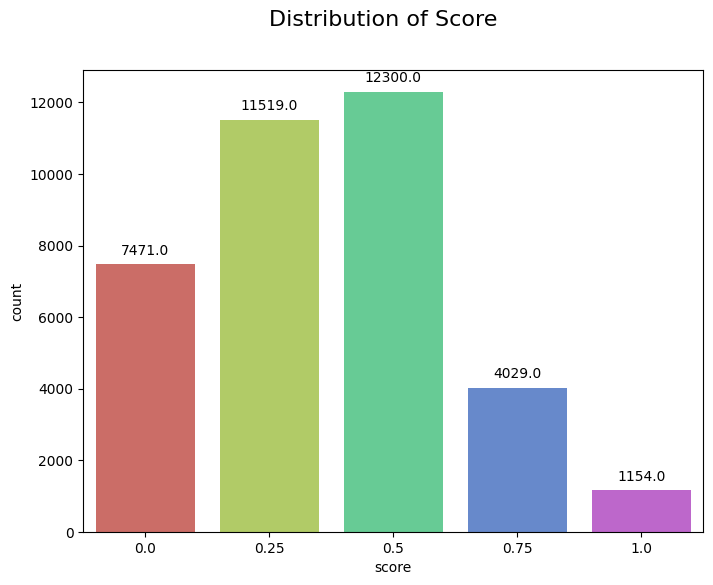

In [5]:
# plot distribution
fig, ax = plt.subplots(figsize=(8, 6)) 
fig.suptitle('Distribution of Score', size=16)


plot = sns.countplot(x='score', data=df, palette='hls', ax=ax)

# add the number of each category
for p in plot.patches:
    ax.annotate(format(p.get_height()),  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center',  
                va = 'center',  
                xytext = (0, 10), 
                textcoords = 'offset points',
                fontsize = 10)

plt.savefig("results/Distribution of Score.png")
plt.show()

C:\Users\86188\AppData\Local\Temp\ipykernel_15444\2722586504.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')


Text(0.5, 1.0, 'Top 10 First Phrases (Anchor)')

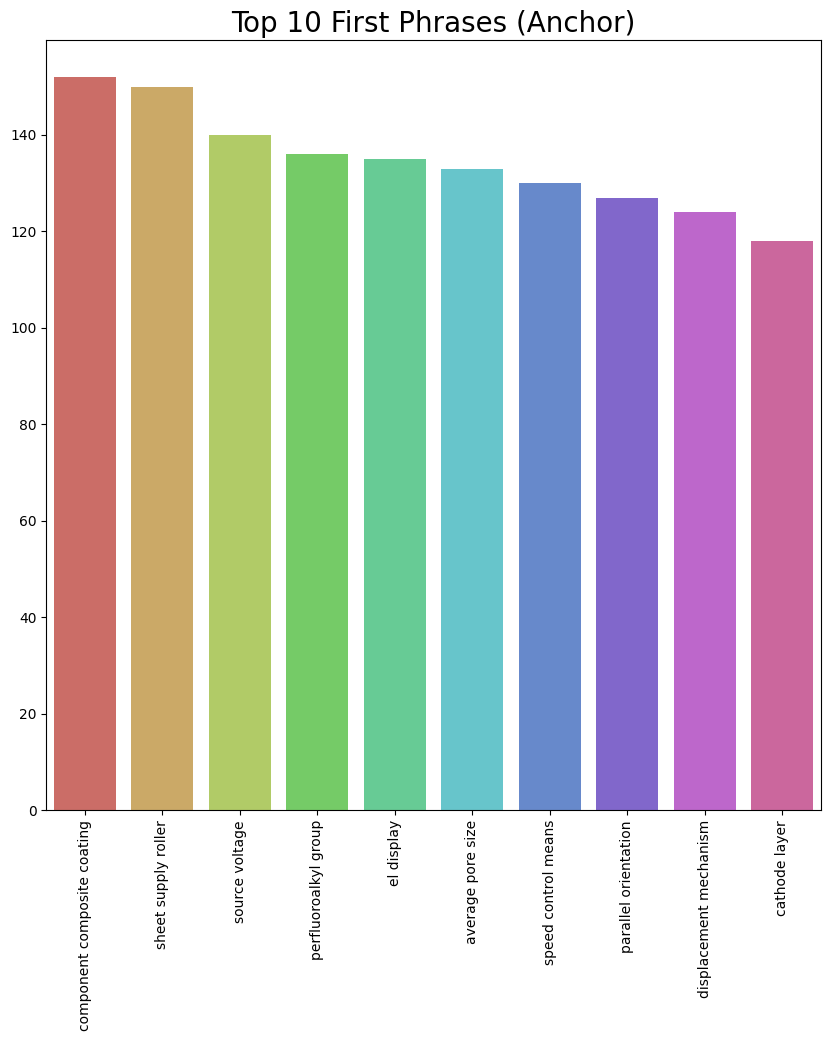

In [32]:
top = Counter([anc for anc in df['anchor']])

top = dict(top.most_common(10))

plt.figure(figsize=(10, 6))

sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
plt.xticks(rotation=90)
plt.title("Top 10 First Phrases (Anchor)", fontsize=20)
plt.savefig("results/Top 10 Anchor.png")

C:\Users\86188\AppData\Local\Temp\ipykernel_15444\1655961374.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='section', data=df, palette='rainbow', order = list(sections.keys())[:-1])


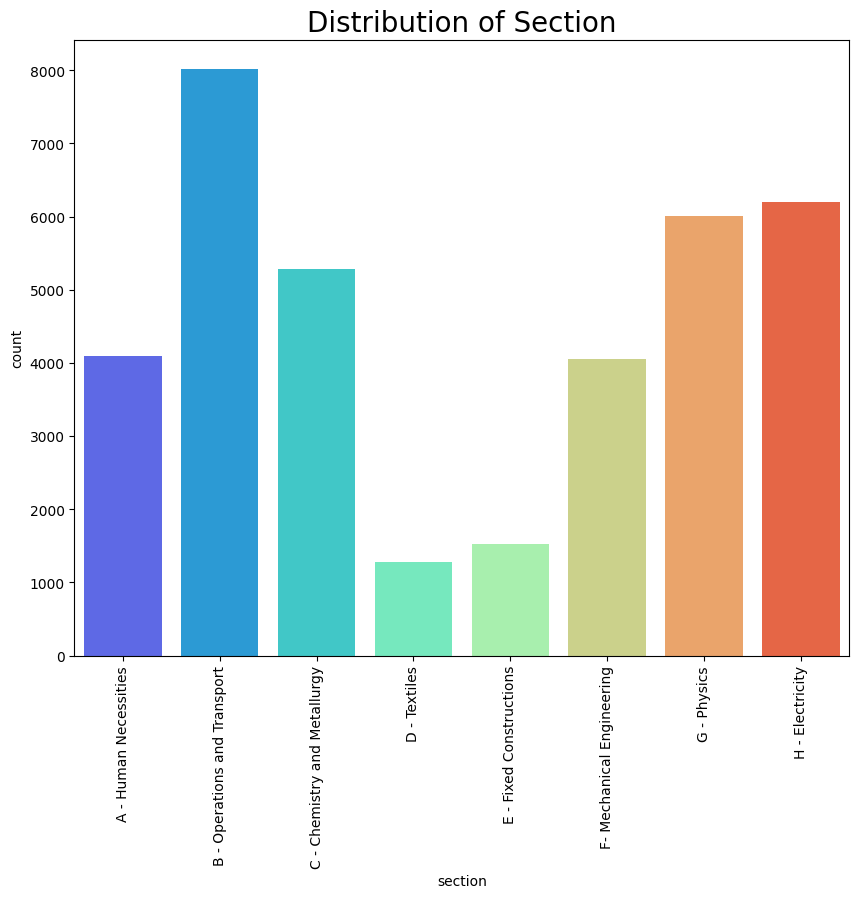

In [36]:
df['section'] = df['context'].astype(str).str[0]
df['classes'] = df['context'].astype(str).str[1:]

sections = {"A" : "A - Human Necessities", 
            "B" : "B - Operations and Transport",
            "C" : "C - Chemistry and Metallurgy",
            "D" : "D - Textiles",
            "E" : "E - Fixed Constructions",
            "F" : "F- Mechanical Engineering",
            "G" : "G - Physics",
            "H" : "H - Electricity",
            "Y" : "Y - Emerging Cross-Sectional Technologies"}

plt.figure(figsize=(10, 8))

sns.countplot(x='section', data=df, palette='rainbow', order = list(sections.keys())[:-1])
plt.xticks([0, 1,2, 3, 4, 5, 6, 7], list(sections.values())[:-1], rotation='vertical')
plt.title("Distribution of Section", fontsize=20)

plt.savefig("results/Distribution of Section.png")


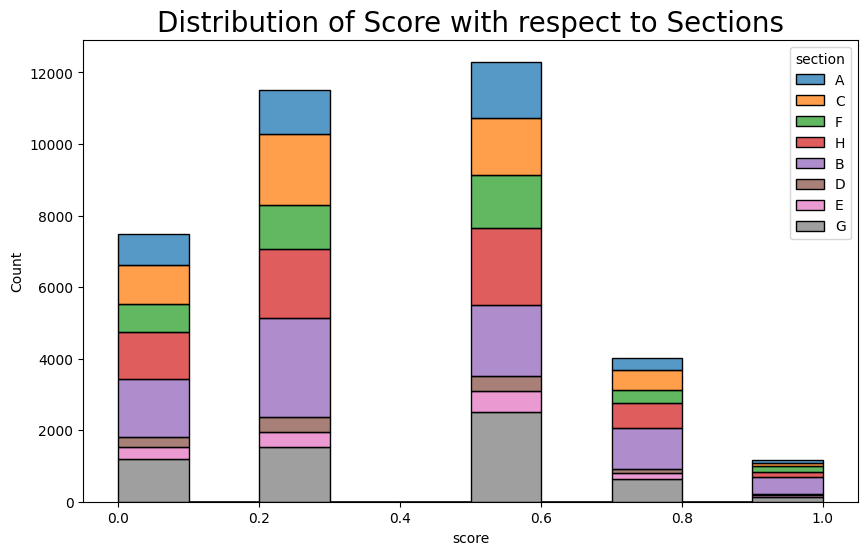

In [7]:
plt.figure(figsize=(10, 6))

sns.histplot(x='score', hue='section', data=df, bins=10, multiple="stack")
plt.title("Distribution of Score with respect to Sections", fontsize=20)

plt.savefig("results/Distribution of score and sections.png")
plt.show()

In [8]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor


In [9]:
# Transfer Dataframe to dataset
ds = Dataset.from_pandas(df)

In [10]:

model_nm = 'microsoft/deberta-v3-small'
tokz = AutoTokenizer.from_pretrained(model_nm)

c:\Users\86188\.conda\envs\alms\Lib\site-packages\transformers\convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [37]:
# tokenize
def tok_func(x): return tokz(x["input"])

tok_ds = ds.map(tok_func, batched=True)

Map: 100%|██████████| 36473/36473 [00:04<00:00, 8005.55 examples/s] 


In [12]:
row = tok_ds[0]

In [13]:
# change score name for input format.
tok_ds = tok_ds.rename_columns({'score':'labels'})


In [14]:
# Seperate train, valid, test dataset 
train_test_split = tok_ds.train_test_split(test_size=0.2, seed=777)

validation_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=777)

train_ds = train_test_split["train"]
valid_ds = validation_test_split["train"]
test_ds = validation_test_split["test"]


In [38]:
print("Training dataset length:", len(train_ds))
print("Validation dataset length:", len(valid_ds))
print("Test dataset length:", len(test_ds))

Training dataset length: 29178
Validation dataset length: 3647
Test dataset length: 3648


In [15]:

#Record training process
training_stats = {
    'train_loss': [],
    'eval_pearson': []
}
# Perason correlation calculation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.squeeze(predictions)
    pearson_corr = pearsonr(predictions, labels)[0]
    training_stats['eval_pearson'].append(pearson_corr)
    return {'eval_pearson': pearson_corr}


# record loss in each epoch
class LossRecorder(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        global current_epoch
        current_epoch = state.epoch

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            training_stats['train_loss'].append(logs['loss'])

In [16]:
# Training Parameter
bs = 16
epochs = 5
lr = 2e-5


args = TrainingArguments(
                        output_dir='results/',            
                        evaluation_strategy="epoch",       
                        save_strategy="epoch",             
                        learning_rate=lr,
                        warmup_ratio=0.1, 
                        lr_scheduler_type='cosine', 
                        per_device_train_batch_size=bs, 
                        per_device_eval_batch_size=bs*2,
                        num_train_epochs=epochs, 
                        weight_decay=0.01, 
                        fp16=False,
                        report_to='none')

model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

trainer = Trainer(model, 
                  args, 
                  train_dataset=train_ds,
                  eval_dataset=valid_ds,
                  tokenizer=tokz, 
                  compute_metrics=compute_metrics,
                  callbacks=[LossRecorder()])


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
trainer.train()

  5%|▌         | 500/9120 [18:21<5:30:38,  2.30s/it]

{'loss': 0.0764, 'grad_norm': 1.013001561164856, 'learning_rate': 1.0964912280701755e-05, 'epoch': 0.27}


 11%|█         | 1000/9120 [37:37<5:21:40,  2.38s/it]

{'loss': 0.0384, 'grad_norm': 2.4684712886810303, 'learning_rate': 1.999432822047469e-05, 'epoch': 0.55}


 16%|█▋        | 1500/9120 [56:33<4:45:43,  2.25s/it]

{'loss': 0.0318, 'grad_norm': 1.1500333547592163, 'learning_rate': 1.9747816977079672e-05, 'epoch': 0.82}


                                                       
 20%|██        | 1824/9120 [1:09:52<4:17:00,  2.11s/it]

{'eval_pearson': 0.7915244867146154, 'eval_loss': 0.031194668263196945, 'eval_runtime': 74.2419, 'eval_samples_per_second': 49.123, 'eval_steps_per_second': 1.536, 'epoch': 1.0}


 22%|██▏       | 2000/9120 [1:16:47<4:24:21,  2.23s/it] 

{'loss': 0.0284, 'grad_norm': 0.6857388615608215, 'learning_rate': 1.9145390517435013e-05, 'epoch': 1.1}


 27%|██▋       | 2500/9120 [1:35:33<4:10:21,  2.27s/it]

{'loss': 0.0249, 'grad_norm': 0.8347027897834778, 'learning_rate': 1.8209044817066617e-05, 'epoch': 1.37}


 33%|███▎      | 3000/9120 [1:55:55<3:43:10,  2.19s/it]

{'loss': 0.0235, 'grad_norm': 1.2467454671859741, 'learning_rate': 1.6972968010939953e-05, 'epoch': 1.64}


 38%|███▊      | 3500/9120 [2:14:17<3:24:48,  2.19s/it]

{'loss': 0.023, 'grad_norm': 0.5707683563232422, 'learning_rate': 1.5482292106025222e-05, 'epoch': 1.92}


                                                       
 40%|████      | 3648/9120 [2:20:50<3:11:11,  2.10s/it]

{'eval_pearson': 0.819779742557482, 'eval_loss': 0.025975601747632027, 'eval_runtime': 72.0838, 'eval_samples_per_second': 50.594, 'eval_steps_per_second': 1.581, 'epoch': 2.0}


 44%|████▍     | 4000/9120 [2:33:46<3:08:16,  2.21s/it] 

{'loss': 0.0196, 'grad_norm': 0.7952267527580261, 'learning_rate': 1.3791445107926478e-05, 'epoch': 2.19}


 49%|████▉     | 4500/9120 [2:52:10<2:51:20,  2.23s/it]

{'loss': 0.0168, 'grad_norm': 0.4406569302082062, 'learning_rate': 1.1962163729221362e-05, 'epoch': 2.47}


 55%|█████▍    | 5000/9120 [3:10:36<2:31:40,  2.21s/it]

{'loss': 0.0173, 'grad_norm': 0.7905439138412476, 'learning_rate': 1.0061239240100326e-05, 'epoch': 2.74}


                                                       
 60%|██████    | 5472/9120 [3:30:25<2:33:46,  2.53s/it]

{'eval_pearson': 0.8296576067548892, 'eval_loss': 0.026276325806975365, 'eval_runtime': 90.875, 'eval_samples_per_second': 40.132, 'eval_steps_per_second': 1.254, 'epoch': 3.0}


 60%|██████    | 5500/9120 [3:31:31<2:19:30,  2.31s/it] 

{'loss': 0.0167, 'grad_norm': 0.7357966899871826, 'learning_rate': 8.158078765482796e-06, 'epoch': 3.02}


 66%|██████▌   | 6000/9120 [3:50:24<2:00:59,  2.33s/it]

{'loss': 0.0134, 'grad_norm': 0.6151658296585083, 'learning_rate': 6.322171071261071e-06, 'epoch': 3.29}


 71%|███████▏  | 6500/9120 [4:09:03<1:35:07,  2.18s/it]

{'loss': 0.0135, 'grad_norm': 1.3958693742752075, 'learning_rate': 4.620549369644576e-06, 'epoch': 3.56}


 77%|███████▋  | 7000/9120 [4:27:18<1:16:02,  2.15s/it]

{'loss': 0.0132, 'grad_norm': 0.3374404311180115, 'learning_rate': 3.1153437824164834e-06, 'epoch': 3.84}


                                                       
 80%|████████  | 7296/9120 [4:39:19<1:03:10,  2.08s/it]

{'eval_pearson': 0.8353114168207231, 'eval_loss': 0.023478401824831963, 'eval_runtime': 73.316, 'eval_samples_per_second': 49.744, 'eval_steps_per_second': 1.555, 'epoch': 4.0}


 82%|████████▏ | 7500/9120 [4:46:56<1:03:51,  2.37s/it] 

{'loss': 0.0134, 'grad_norm': 0.4202839732170105, 'learning_rate': 1.861512827298051e-06, 'epoch': 4.11}


 88%|████████▊ | 8000/9120 [5:06:03<41:25,  2.22s/it]  

{'loss': 0.0119, 'grad_norm': 0.8445876240730286, 'learning_rate': 9.048367560708604e-07, 'epoch': 4.39}


 93%|█████████▎| 8500/9120 [5:25:35<24:12,  2.34s/it]

{'loss': 0.0119, 'grad_norm': 0.3118821084499359, 'learning_rate': 2.802460122970241e-07, 'epoch': 4.66}


 99%|█████████▊| 9000/9120 [5:45:59<05:03,  2.53s/it]

{'loss': 0.0113, 'grad_norm': 0.9289356470108032, 'learning_rate': 1.0545840490313597e-08, 'epoch': 4.93}


                                                     
100%|██████████| 9120/9120 [5:52:02<00:00,  2.08s/it]

{'eval_pearson': 0.8344350096747727, 'eval_loss': 0.0230964757502079, 'eval_runtime': 75.3371, 'eval_samples_per_second': 48.409, 'eval_steps_per_second': 1.513, 'epoch': 5.0}


100%|██████████| 9120/9120 [5:52:07<00:00,  2.32s/it]

{'train_runtime': 21127.9112, 'train_samples_per_second': 6.905, 'train_steps_per_second': 0.432, 'train_loss': 0.022385271821628538, 'epoch': 5.0}


TrainOutput(global_step=9120, training_loss=0.022385271821628538, metrics={'train_runtime': 21127.9112, 'train_samples_per_second': 6.905, 'train_steps_per_second': 0.432, 'total_flos': 853719963883440.0, 'train_loss': 0.022385271821628538, 'epoch': 5.0})

In [18]:
#predict
preds = trainer.predict(test_ds).predictions.astype(float)
preds = np.clip(preds, 0, 1)

100%|██████████| 114/114 [01:17<00:00,  1.47it/s]


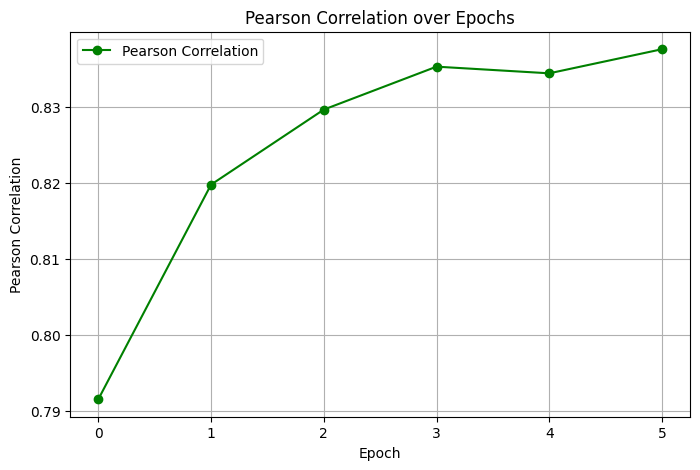

In [28]:
# plot Pearson Correlation in each epoch
plt.figure(figsize=(8, 5))
epoch=range(0,6)
plt.plot(epoch, training_stats['eval_pearson'], label='Pearson Correlation', color='green', marker='o')
plt.title('Pearson Correlation over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.legend()
plt.savefig('results/Pearson Correlation in Each Epoch.png')
plt.show()

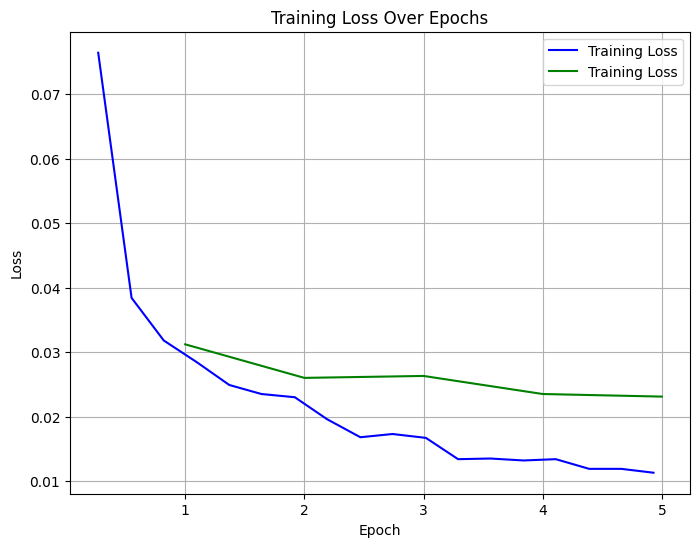

In [45]:
loss_epochs = [0.27, 0.55, 0.82, 1.1, 1.37, 1.64, 1.92, 2.19, 2.47, 2.74, 3.02, 3.29, 3.56, 3.84, 4.11, 4.39, 4.66, 4.93]
eval_epochs =[1,2,3,4,5]
eval_losses = [0.0312,0.0260, 0.0263, 0.0235, 0.0231]
plt.figure(figsize=(8, 6))
plt.plot(loss_epochs, training_stats['train_loss'], label='Training Loss', color='b')
plt.plot(eval_epochs, eval_losses,label='Training Loss', color='g' )
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('results/Training Loss in Each Epoch.png')
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Evaluate and Calculate MSE MAE R2 Pearson correlation
true_labels = np.array(test_ds['labels'])

mse = mean_squared_error(true_labels, preds)
mae = mean_absolute_error(true_labels, preds)
r2 = r2_score(true_labels, preds)
pearson_corr_test, p_value = pearsonr(true_labels,preds)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print("Pearson Correlation Coefficient of Test set:", pearson_corr_test)
print("P-value:", p_value)


MSE: 0.02196823533819891
MAE: 0.09971182739680348
R²: 0.6768064526462791
Pearson Correlation Coefficient of Test set: 0.8356887943637641
P-value: 0.0


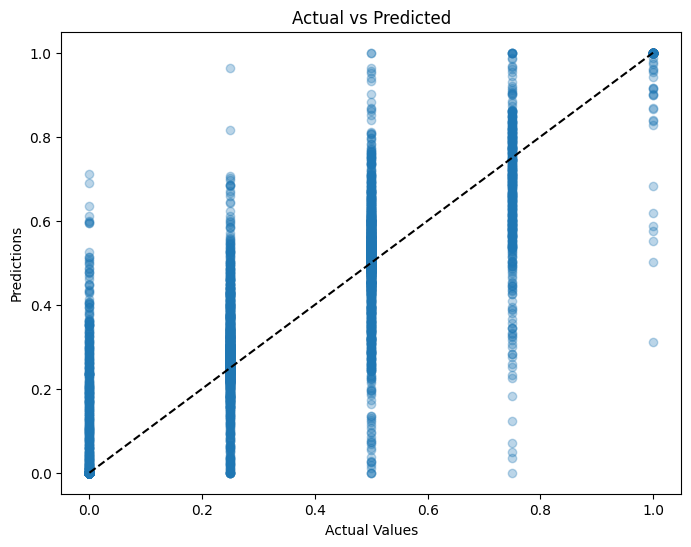

In [47]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(true_labels, preds, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)], 'k--') 
plt.title('Actual vs Predicted')
plt.savefig('results/Scatter Plot.png')
plt.show()



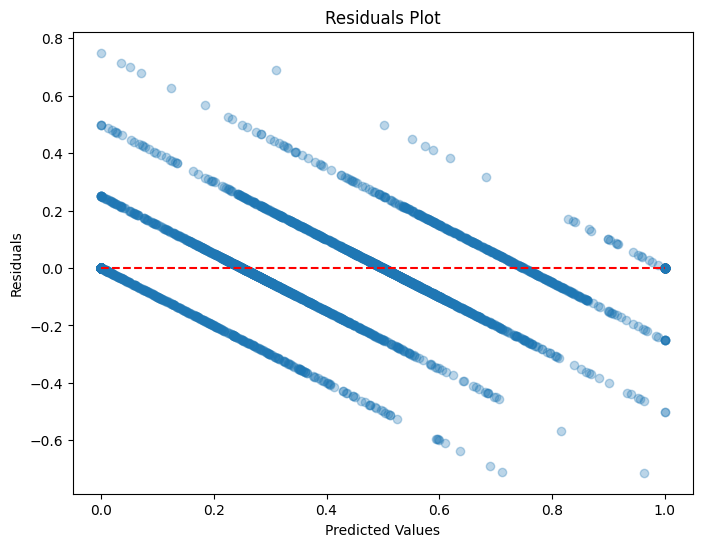

In [48]:
# Residuals Plot
residuals = true_labels - preds
plt.figure(figsize=(8, 6))
plt.scatter(preds, residuals, alpha=0.3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.hlines(y=0, xmin=min(preds), xmax=max(preds), colors='red', linestyles='--')
plt.title('Residuals Plot')
plt.savefig('results/Residuals Plot.png')
plt.show()

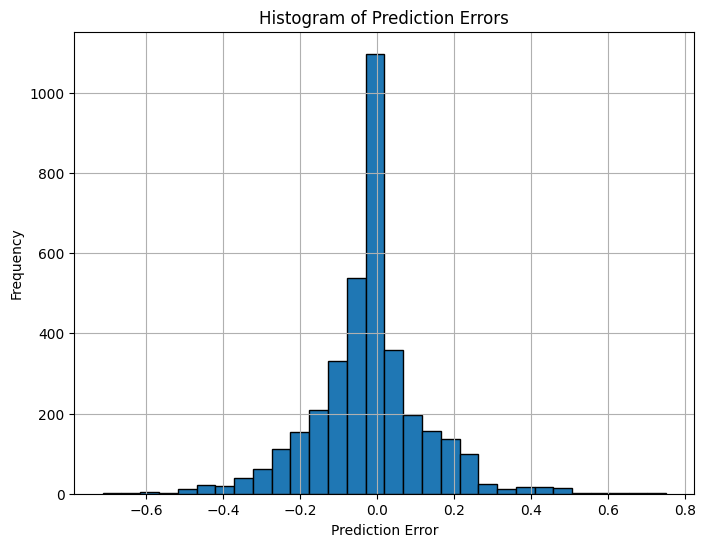

In [26]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('results/Histogram.png')
plt.show()